In [2]:
import pymysql
import time
import datetime
import random
import pandas as pd
import psutil
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.offline
import plotly.io as pio
import plotly
import plotly.graph_objects as go
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import generic_dna
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
from math import pi
from multiprocessing import cpu_count, Manager
from concurrent.futures import ProcessPoolExecutor
import itertools
import pysam
import bioblend
from bioblend import galaxy
from bioblend.galaxy import objects
from bioblend.galaxy.tools.inputs import inputs
import json
import csv
import imp
import logging
from sys import argv, exit, stderr, path
from os import remove, rename, path
from termcolor import colored
from scripts.gfetchseq import gfetchseq

## 1. Preprocessing

### 1a. Interval file from UCSC

In [ ]:
conn = pymysql.connect(host='genome-mysql.cse.ucsc.edu',
                       db='hg38',
                       user='genome')

In [ ]:
cur = conn.cursor()

In [ ]:
cur.execute("SELECT rm.genoName, rm.genoStart, rm.genoEnd, rm.repName, rm.strand FROM rmsk rm WHERE rm.repFamily = 'L1' AND (genoEnd - genoStart > 5500)")

In [ ]:
with open('source/L1_5500_gh38.bed', 'w') as file:
    for row in cur:
        file.write(f'{row[0]}\t{row[1]}\t{row[2]}\t{row[3]}\t0\t{row[4]}\n')

In [2]:
interval_df = pd.read_csv('L1_5500_gh38.bed', sep='\t', skiprows=(0), header=(0))

In [3]:
interval_df.head(5)

,genoName,genoStart,genoEnd,strand,repName
0,chr1,100662981,100669120,-,L1PA4
1,chr1,49282507,49288376,+,L1PA2
2,chr1,146798613,146805199,+,L1PB1
3,chr1,239071918,239078057,+,L1MA2
4,chr1,38402815,38409352,+,L1PB1


In [4]:
interval_df.dtypes

genoName     object
genoStart     int64
genoEnd       int64
strand       object
repName      object
dtype: object

In [5]:
# remove unwanted
keep_list = ['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5']
drop_list = []
for index, row in interval_df.iterrows():
    if row[4] not in keep_list:
        drop_list.append(index)
df_clean = interval_df.drop(drop_list)
df_interval = df_clean.reset_index(drop=True)
df_interval[:5]

,genoName,genoStart,genoEnd,strand,repName
0,chr1,100662981,100669120,-,L1PA4
1,chr1,49282507,49288376,+,L1PA2
2,chr1,48363803,48369929,-,L1PA3
3,chr1,49934841,49940864,+,L1PA3
4,chr1,68681498,68687636,-,L1PA4


In [6]:
# add upstream flank to strands
# (+) start-300 / (-) end+300
for index, row in df_interval.iterrows():
    if row[3] == '-':
        df_interval.at[index,'genoEnd'] += 300
    if row[3] == '+':
        df_interval.at[index,'genoStart'] -= 300

In [7]:
# create new .interval file for processing in Galaxy
df_interval.to_csv("work/Flank_L1.interval", sep="\t", index=False)

### 1b. Fasta from Galaxy

In [8]:
# gfetchseq [interval_file] [genome] [api_key] [upper? yes/no] [clean Galaxy history? yes/no]
# extract sequences, converts to upper and format IDs
interval = 'work/Flank_L1.interval'
genome = 'hg38'
apik = 'ec09849dc5c8d075f18ff9cb7e9e98f8'
gfetchseq(interval, genome, apik, 'yes', 'yes')

Connecting to Galaxy server...
Connected to user account lexxxa
Converted work/Flank_L1.interval to work/Flank_L1.bed
Uploading work/Flank_L1.bed to Galaxy...
File uploaded in 0:03:08
Retrieving Dataset...
Fetching DNA sequences from hg38 in fasta format...
Extraction completed in 0:03:37
Formatting fasta file...
Converted 5439 records to upper case
Formatted fasta records IDs
Removing files from Galaxy...
Purge completed in 0:00:01
Full process completed in 0:08:23


In [10]:
# check ID and sequence of first record
print(next(SeqIO.parse('work/Flank_L1.fasta', 'fasta')).id)
print(next(SeqIO.parse('work/Flank_L1.fasta', 'fasta')).seq._data[:100])

chr1_100662981-100669420_L1PA4-
TGTAATTTTCTTTTTGTTTTAATTTGCACTTCTTTGAGTCCTAGTGAGATCATTTACATTTACTGGATTGTTATATTTTTATTATGTGAATGGAAGATTC


## 2. Pairwise alignment

### 2a. Alignment process for a single primer

In [11]:
%cd work

/mnt/nfs/home/244205/000000-My_Documents/VM-home/l1_parse/work


In [21]:
# setup 255 primer
primerC = 'TCCGTCACCCCTTTCTTTGACTC'
primer_seq = Seq(primerC, generic_dna)
primer_seq

Seq('TCCGTCACCCCTTTCTTTGACTC', DNAAlphabet())

In [28]:
# reverse complement
primer_rc_seq = primer_seq.reverse_complement()
primer_rc_seq

Seq('GAGTCAAAGAAAGGGGTGACGGA', DNAAlphabet())

In [36]:
# pairwise2 alignment against l1 full-length sequences 
# function cuts the sequence after primer 3'end: ]primer - L1]
# max score = full match = primer length, max gaps allowed = 3 / min allowed score = primer length - 3
def align_primer_and_strip(recs_q, primer_rc_seq, recs_list, align_q, new_recs_list, errors):
    record = recs_q.get()
    alignment = pairwise2.align.localms(record.seq, primer_rc_seq, 1, 0, -1, -1, penalize_end_gaps = (True, False))
    if int(alignment[0][2]) >= len(primer_rc_seq._data) - errors:
        align_q.put(f"{record.id}\n{format_alignment(*alignment[0])}")
        new_seq = record.seq[alignment[0][4]:]
        new_rec = SeqRecord(Seq(new_seq, generic_dna))
        new_rec.id = record.id
        new_rec.description = ''
        new_rec.name = record.id
        new_recs_list.append(new_rec)
        recs_list.append(record)

In [30]:
# write alignment file with alignement result strings stored in queue
def write_align_file(text_file, align_q):
    file = open(text_file,"w")
    for i in range(align_q.qsize()):
        align_rec = align_q.get(True, 0.05)
        file.write(align_rec)
    file.close()

In [31]:
# write fasta file with L1 cut from primer's end
def write_fasta_with_l1(fasta_file, new_recs_list):
    rec_gen = (rec for rec in new_recs_list)
    count = SeqIO.write(rec_gen, fasta_file, "fasta")
    print(f"Wrote {count} records with primer")

In [32]:
# write fasta file with processed fasta records appended to list
def write_fasta_with_primer(fasta_file, recs_list):
    rec_gen = (rec for rec in recs_list)
    count = SeqIO.write(rec_gen, fasta_file, "fasta")
    print(f"Wrote {count} records with primer")

In [37]:
# initialize multiprocessing client, queues and variables
manager = Manager()
fasta_recs_q = manager.Queue()
align_recs_q = manager.Queue()
new_recs_list = manager.list()
primer_recs_list = manager.list()
number_of_cpus = cpu_count()
number_of_cpus

8

In [38]:
# add full-length L1s to ref seq queue
for record in SeqIO.parse('Flank_L1.fasta', 'fasta'):
    fasta_recs_q.put(record)
fasta_recs_q.qsize()

5439

In [ ]:
# parallel processing of ref seq queue in align_primer_and_strip()
max_gaps = 3
start = time.time()
with ProcessPoolExecutor(max_workers=number_of_cpus) as extract_and_align:
    for i in range(fasta_recs_q.qsize()):
        extract_and_align.submit(align_primer_and_strip, 
                                 fasta_recs_q, 
                                 primer_rc_seq, 
                                 primer_recs_list, 
                                 align_recs_q,
                                 new_recs_list,
                                 max_gaps)
end = time.time()
print(f'{str(datetime.timedelta(seconds=int(end - start)))}')

In [30]:
# check = both sizes of align queue and result list must match
print(align_recs_q.qsize(), len(primer_recs_list))

3617 3617


In [27]:
# dump result list in fasta file
fasta_file = "5']c255-L1]3'.fasta"
write_fasta_with_l1(fasta_file, new_recs_list)

Wrote 0 records with primer


In [31]:
# dump align queue in text file
align_file = "../result/pairwise2_255.txt"
write_align_file(align_file, align_recs_q)

In [32]:
# dump result list in fasta file
fasta_file = "Flank_5UTR_255_L1.fasta"
write_fasta_with_primer(fasta_file, primer_recs_list)

Wrote 3617 records with primer


### 2b. Alignment process for a list of primer variants

###### List of p489

In [9]:
# generate a list of primer sequences
p489_deg = 'CTTCCCARCTRCTTTRTTTACCTA'
bases = ['A', 'G']
cases = [b1 + b2 + b3 for b1 in bases for b2 in bases for b3 in bases]
p489_deg_list = []
primer = list(p489_deg)
for triplet in cases:
    primer[7] = triplet[0]
    primer[10] = triplet[1]
    primer[15] = triplet[2]
    p489_deg_list.append(Seq(''.join(primer), generic_dna))
p489_deg_list

[Seq('CTTCCCAACTACTTTATTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAACTACTTTGTTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAACTGCTTTATTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAACTGCTTTGTTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAGCTACTTTATTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAGCTACTTTGTTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAGCTGCTTTATTTACCTA', DNAAlphabet()),
 Seq('CTTCCCAGCTGCTTTGTTTACCTA', DNAAlphabet())]

In [10]:
# reverse complement
p489_rc_deg_list = [seq.reverse_complement() for seq in p489_deg_list]
p489_rc_deg_list

[Seq('TAGGTAAATAAAGTAGTTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAACAAAGTAGTTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAATAAAGCAGTTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAACAAAGCAGTTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAATAAAGTAGCTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAACAAAGTAGCTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAATAAAGCAGCTGGGAAG', DNAAlphabet()),
 Seq('TAGGTAAACAAAGCAGCTGGGAAG', DNAAlphabet())]

##### List of p394

In [45]:
p394_deg_list = [Seq('TGTGCTAGCAATCAGCGAGAT', generic_dna), Seq('TGTGCTAGCAATCAGCGCGAT', generic_dna)]
p394_rc_deg_list = [seq.reverse_complement() for seq in p394_deg_list]
p394_rc_deg_list

[Seq('ATCTCGCTGATTGCTAGCACA', DNAAlphabet()),
 Seq('ATCGCGCTGATTGCTAGCACA', DNAAlphabet())]

In [11]:
# align_var_primer_and_strip() takes a list of sequences as argument instead of single primer seq
# max score = primer length / min allowed score = primer length - 3
def align_var_primer_and_strip(recs_q, primer_rc_seq_list, recs_list, align_q, new_recs_list, errors):
    record = recs_q.get(True, 0.05)
    for primer in primer_rc_seq_list:
        min_score = len(primer._data) - errors
        alignment = pairwise2.align.localms(record.seq, primer, 1, 0, -1, -1, penalize_end_gaps = (True, False))
        if int(alignment[0][2]) >= min_score:
            align_q.put(f"{record.description}\n{format_alignment(*alignment[0])}")
            new_seq = record.seq[alignment[0][4]:]
            new_rec = SeqRecord(Seq(new_seq, generic_dna))
            new_rec.id = record.id
            new_rec.description = ''
            new_rec.name = record.id
            new_recs_list.append(new_rec)
            recs_list.append(record)
            break

In [14]:
# initialize multiprocessing clients and variables
manager = Manager()
fasta_recs_q = manager.Queue()
align_recs_q = manager.Queue()
new_recs_list = manager.list()
primer_recs_list = manager.list()
number_of_cpus = cpu_count()

In [15]:
# add full-length L1s to fasta queue
for record in SeqIO.parse('Flank_L1.fasta', 'fasta'):
    fasta_recs_q.put(record)
fasta_recs_q.qsize()

5439

In [17]:
# parallel processing of records in align_var_primer_and_strip()
max_gaps = 3
start = time.time()
with ProcessPoolExecutor(max_workers=number_of_cpus) as extract_and_align:
    for i in range(fasta_recs_q.qsize()):
        extract_and_align.submit(align_var_primer_and_strip, 
                                fasta_recs_q, 
                                p489_rc_deg_list, 
                                primer_recs_list, 
                                align_recs_q,
                                new_recs_list,
                                max_gaps)
end = time.time()
print(f'{str(datetime.timedelta(seconds=int(end - start)))}')

Process Process-9:
Process Process-8:
Process Process-4:
Process Process-7:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-6:
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/concurrent/futures/process.py", line 169, in _pr

KeyboardInterrupt: 

  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/managers.py", line 881, in RebuildProxy
    return func(token, serializer, incref=incref, **kwds)
Process Process-10:
FileNotFoundError: [Errno 2] No such file or directory
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/concurrent/futures/process.py", line 169, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/managers.py", line 930, in AutoProxy
    incref=incref)
Traceback (most recent call last):
  File "/home/lexa/anaconda3/envs/bio/lib/python3.6/multiprocessing/managers.py", line 881, in RebuildProxy
    return func(token, serializer, incref=incref, **kwds)
FileNotFoundError: [Errno 2] No such file or directory
FileNotFoundError: [Errno 2] No such file or directory
  File "/home/lexa/anaconda3/envs

In [ ]:
out_fasta = f'{in_fasta[:-6]}_dup.fasta'
count = SeqIO.write(recs_gen, out_fasta, 'fasta')    

In [49]:
align_file = "../result/pairwise2_394.txt"
write_align_file(align_file, align_recs_q)

In [50]:
fasta_file = "Flank_5UTR_394_L1.fasta"
write_fasta_with_primer(fasta_file, primer_recs_list)

Wrote 3606 records with primer


### 2c. Extract L1 sequences from 3' end of primer

In [4]:
%cd work

[Errno 2] No such file or directory: 'work'
/home/lexa/bioinformatics/Tasks/L1_Parse_NEW/work


In [5]:
f255 = 'Flank_5UTR_255_L1.fasta'
f394 = 'Flank_5UTR_394_L1.fasta'
f489 = 'Flank_5UTR_489_L1.fasta'

## 3. Statistics on primer distribution

In [52]:
%matplotlib inline

In [70]:
# Cut leaving only 300bp flank and rename as 3-letters code '255', '394', '489' 
def copy_and_rename(*fasta):
    for fasta_file in fasta:
        recs_list = []
        f_name = fasta_file[11:-9]
        for rec in SeqIO.parse(fasta_file, 'fasta'):
            new_seq = rec.seq._data[:300]
            new_id = rec.id
            new_rec = SeqRecord(Seq(new_seq, generic_dna))
            new_rec.id = new_id
            recs_list.append(new_rec)
        recs_gen = (rec for rec in recs_list)
        out_fasta = f'{f_name}_flank.fasta'
        count = SeqIO.write(recs_gen, out_fasta, 'fasta')
        print(f'{count} records reduced to 300bp flank in "{out_fasta}"')          

In [71]:
f255 = 'Flank_5UTR_255_L1.fasta'
f394 = 'Flank_5UTR_394_L1.fasta'
f489 = 'Flank_5UTR_489_L1.fasta'
copy_and_rename(f255, f394, f489)

3617 records reduced to 300bp flank in "255_flank.fasta"
3606 records reduced to 300bp flank in "394_flank.fasta"
4558 records reduced to 300bp flank in "489_flank.fasta"


In [78]:
# Function returning the list of intersecting records in a list of fasta files
def get_intersection(*fasta):
    rec_lists = []
    for fasta_file in fasta:
        temp_list = [rec.id for rec in SeqIO.parse(fasta_file, 'fasta')]
        rec_lists.append(temp_list)
    
    match_list = list(set.intersection(*[set(_list) for _list in rec_lists]))
    
    return match_list

In [79]:
# Function returning the list of intersecting records in a list of fasta files
# specifying a name present in some records only
def get_intersection_with_name(name, *fasta):
    rec_lists = []
    for fasta_file in fasta:
        temp_list = [rec.id for rec in SeqIO.parse(fasta_file, 'fasta') if name in rec.id]
        rec_lists.append(temp_list)
    
    match_list = list(set.intersection(*[set(_list) for _list in rec_lists]))
    
    return match_list

In [75]:
# takes a ref sequences fasta, a req names list, and a list of fasta files 
# each containing a subset of sequences in the ref
# returns a paands with count per name in provided list
def get_light_stats(ref_fasta, req_names, *fasta):
    
    count_dict = {key: 0 for key in req_names}

    # ref records counts
    for rec in SeqIO.parse(ref_fasta, "fasta"):
        for req_name in req_names:
            if req_name in rec.id:
                count_dict[req_name] += 1
                break
    total_list = [count for count in count_dict.values()]
    df_dict = {'name': req_names, 'n': total_list}
    
    # req records counts
    for fasta_file in fasta:
        count_dict = count_dict.fromkeys(count_dict, 0)
        for rec in SeqIO.parse(fasta_file, "fasta"):
            for req_name in req_names:
                if req_name in rec.id:
                    count_dict[req_name] += 1
                    break    
        count_list = [count for count in count_dict.values()]
        key = fasta_file[:4]
        df_dict[key] = count_list

    light_stat_df = pd.DataFrame.from_dict(df_dict)

    return light_stat_df 

In [87]:
# takes a ref fasta, element names list, and x fasta request files 
# with names as shortest id "255", "489"..
# max 3 request sequences
# input fasta file MUST start with primer 3-letters code '255', '394'..
def get_full_stats(ref, names, *fasta):
    
    req_list = [name[:4] for name in fasta]
    fasta_list = [file for file in fasta]
    
    # elements count in ref
    count_dict = {key: 0 for key in names}
    for rec in SeqIO.parse(ref, "fasta"):
        for name in names:
            if name in rec.id:
                count_dict[name] += 1
                break
    total_list = [count for count in count_dict.values()]
    df_dict = {'name': names, 'n': total_list}
    
    # 'with' column: req sequences count
    for fasta_file in fasta:
        count_dict = {key: 0 for key in names}
        for rec in SeqIO.parse(fasta_file, "fasta"):
            for name in names:
                if name in rec.id:
                    count_dict[name] += 1
                    break    
        req_count_list = [count for count in count_dict.values()]
        col_name = f'with {fasta_file[:4]}'
        df_dict[col_name] = req_count_list

    stat_df = pd.DataFrame.from_dict(df_dict)
    stat_df.columns.name = 'idx'
    
    # 'with all' column: intersection of req sequences counts
    # call of get_ids_with_all_primers(*fasta)
    count_dict = {key: 0 for key in names}
    all_list = get_intersection(*fasta)
    for _id in all_list:
        for name in names:
            if name in _id:
                count_dict[name] += 1
    req_count_list = [count for count in count_dict.values()]
    stat_df['with all'] = req_count_list
    
    if len(fasta) == 2:
        # 'only req' columns: 'with all' - 'with req'
        count_dict = {key: 0 for key in names}
        for req_name in req_list:
            col_name = f'only {req_name}'
            col_with = f'with {req_name}'
            stat_df[col_name] = stat_df[col_with] - stat_df['with all']
    
    if len(fasta) == 3:
        for fasta_file in fasta:
            if fasta_file == fasta[0]:
                ridx = 0
                for name in names:
                    req_name = fasta_file[:4]
                    interAB = get_intersection_with_name(name, fasta[0], fasta[1])
                    interAC = get_intersection_with_name(name, fasta[0], fasta[2])
                    only_col = f'only {req_name}'
                    with_col = f'with {req_name}'
                    stat_df.loc[ridx, only_col] = stat_df.loc[ridx, with_col] + stat_df.loc[ridx, 'with all'] - len(interAB) - len(interAC)
                    ridx += 1
            if fasta_file == fasta[1]:
                ridx = 0
                for name in names:
                    req_name = fasta_file[:4]
                    interAB = get_intersection_with_name(name, fasta[0], fasta[1])
                    interBC = get_intersection_with_name(name, fasta[1], fasta[2])
                    only_col = f'only {req_name}'
                    with_col = f'with {req_name}'
                    stat_df.loc[ridx, only_col] = stat_df.loc[ridx, with_col] + stat_df.loc[ridx, 'with all'] - len(interAB) - len(interBC)
                    ridx += 1
            if fasta_file == fasta[2]:
                ridx = 0
                for name in names:
                    req_name = fasta_file[:4]
                    interAC = get_intersection_with_name(name, fasta[0], fasta[2])
                    interBC = get_intersection_with_name(name, fasta[1], fasta[2])
                    only_col = f'only {req_name}'
                    with_col = f'with {req_name}'
                    stat_df.loc[ridx, only_col] = stat_df.loc[ridx, with_col] + stat_df.loc[ridx, 'with all'] - len(interAC) - len(interBC)
                    ridx += 1
                    
    if len(fasta) == 2:
        stat_df['without'] = stat_df['n'] - stat_df['with all']
        for idx in range(len(names)):
            for req_name in req_list:
                col_only = f'only {req_name}'
                stat_df.loc[idx, 'without'] -= stat_df.loc[idx, col_only] 
        stat_df.loc[len(stat_df)] = stat_df.iloc[:, 1:].sum().append(pd.Series({'name':'TOTAL'}))
    
    if len(fasta) == 3:
        #idx = 0
        #for name in names:
            #interAB = get_intersection_with_name(name, fasta[0], fasta[1])
            #interBC = get_intersection_with_name(name, fasta[1], fasta[2])
            #interAC = get_intersection_with_name(name, fasta[0], fasta[2])
            #stat_df.loc[idx, f'both {fasta[0][:4]}/{fasta[1][:4]}'] = len(interAB)
            #stat_df.loc[idx, f'both {fasta[1][:4]}/{fasta[2][:4]}'] = len(interBC)
            #stat_df.loc[idx, f'both {fasta[0][:4]}/{fasta[2][:4]}'] = len(interAC)
            #idx+=1
        idx = 0     
        stat_df['without'] = stat_df['n'] + stat_df['with all'] + stat_df['with all']
        for name in names:
            interAB = get_intersection_with_name(name, fasta[0], fasta[1])
            interBC = get_intersection_with_name(name, fasta[1], fasta[2])
            interAC = get_intersection_with_name(name, fasta[0], fasta[2])
            for req_name in req_list:
                col_only = f'only {req_name}'
                stat_df.loc[idx, 'without'] -= stat_df.loc[idx, col_only]
            negative_inter = len(interAB) + len(interBC) + len(interAC)
            stat_df.loc[idx, 'without'] -= negative_inter
            idx += 1            
        stat_df.loc[len(stat_df)] = stat_df.iloc[:, 1:].sum().append(pd.Series({'name':'TOTAL'}))
        pd.options.display.float_format = '{:.0f}'.format
    
    return stat_df 

In [77]:
def nested_donut(l1_df):
    
    labels = l1_df.ix[:4,'name'].tolist()
    counts = l1_df.ix[:4,'n'].tolist()
    colN = len(l1_df.columns)    
    reqN = int((colN-4)/2)
    col_req_names = []
    # adding column names of x 'only req'
    [col_req_names.append(l1_df.columns[3+reqN+i]) for i in range(reqN)]
    # adding 'with all'
    col_req_names.append(l1_df.columns[2+reqN])
    # adding 'without'
    col_req_names.append(l1_df.columns[-1])
    
    # creates list of list of column values: 'only Req'(x), 'with all', 'without'
    counts_l = []
    for ridx in l1_df.index[:-1]:
        count_list = []
        # adds ech req columns values to count_list
        for idx in range(reqN):
            cidx = 3+reqN+idx
            count_list.append(l1_df.iloc[ridx, cidx])

        # add 'with all'(4) values to count_list
        cidx = int(2+reqN)
        count_list.append(l1_df.iloc[ridx, cidx])
        # add 'without'(7) to count_list
        cidx = int(3+(reqN)*2)
        count_list.append(l1_df.iloc[ridx, cidx])
        counts_l.append(count_list)

    counts_primer = list(itertools.chain.from_iterable(counts_l))
    
    colors = ['#1e8d69', '#3ed0a1', '#1e8343', '#0c5828', '#009838']
    colors_primer = ['#ff0000','#8000ff','#ff00ff','#ff8000', 
    '#ff0000','#8000ff','#ff00ff','#ff8000',
    '#ff0000','#8000ff','#ff00ff','#ff8000',
    '#ff0000','#8000ff','#ff00ff','#ff8000',
    '#ff0000','#8000ff','#ff00ff','#ff8000']

    label_1 = mpatches.Patch(color='#ff0000', label=l1_df.columns[5])
    label_2 = mpatches.Patch(color='#8000ff', label=l1_df.columns[6])
    label_all = mpatches.Patch(color='#ff00ff', label=l1_df.columns[4])
    label_without = mpatches.Patch(color='#ff8000', label=l1_df.columns[7])
    plt.legend(handles=[label_1, label_2, label_all, label_without])

    plt.rcParams['figure.figsize'] = [12, 11]
    plt.rcParams['patch.linewidth'] = 0
    
    a = plt.pie(counts, labels=labels, colors=colors, startangle=0, frame=True, radius=5)
    b = plt.pie(counts_primer, colors=colors_primer, startangle=0, radius=3)
    
    
    [x.set_alpha(0.9) for x in a[0]]
    [x.set_alpha(0.8) for x in b[0]]
    
    centre_circle = plt.Circle((0,0),1.5,color='black', fc='white',linewidth=0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    # title string builder for reqs
    reqs = [f'{req[5:]}' for req in col_req_names[:-2]]
    req_string = ''
    for req in reqs:
        if req == reqs[-1]:
            req_string = req_string + req
        else:
            req_string = req_string + req + ' & '
    
    plt.title(f'{req_string} Primers Distribution in >5500 L1s (hg38)')
    plt.axis('equal')
    plt.tight_layout()
    f = f'{req_string}_distribution.png'
    plt.savefig(f)
    plt.show()
    return plt

### 3a. Comparative stats of all 3 primers

In [78]:
# light stats
reff = 'Flank_L1.fasta'
reql = ['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5']
p255 = 'c255_flank.fasta'
p394 = 'c394_flank.fasta'
p489 = 'c489_flank.fasta'
light_df = get_light_stats(reff, reql, p255, p394, p489)
light_df

,name,n,255,394,489
0,L1HS,331,319,318,323
1,L1PA2,1087,1046,1051,1037
2,L1PA3,1567,1232,1429,1423
3,L1PA4,1422,972,636,1075
4,L1PA5,1032,48,172,700


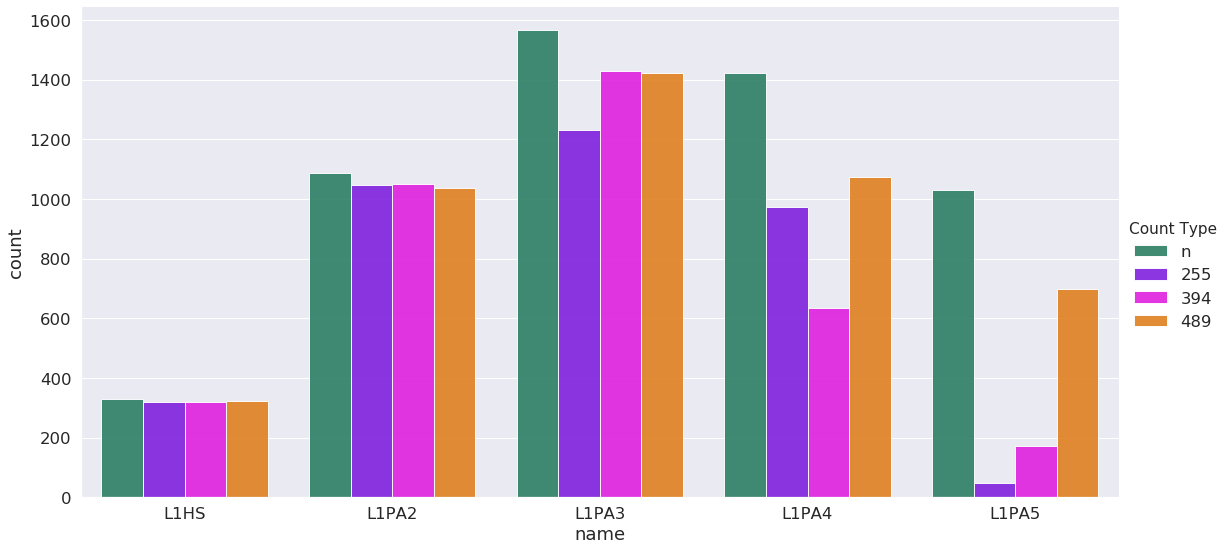

In [79]:
df_melt = light_df.melt('name', var_name='Count Type', value_name='count')
sns.set(font_scale=1.5)
g = sns.catplot(x="name", 
                y="count", 
                kind="bar", 
                hue='Count Type', 
                data=df_melt, 
                height=8, 
                aspect=2, 
                palette=sns.color_palette(['#1e8d69', '#8000ff', '#ff00ff', '#ff8000', '#ff80ff']),
                alpha=.9)
g.savefig('Primers_Histogram.png')

In [88]:
# full stats of all 3 primers
reff = 'Flank_L1.fasta'
p255 = 'c255_flank.fasta'
p394 = 'c394_flank.fasta'
p489 = 'c489_flank.fasta'
names = ['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5']
full_df = get_full_stats(reff, names, p255, p394, p489)
full_df.to_csv(r'primers_full_stats.csv')
full_df.to_html(open('primers_full_stats.html', 'w'))
full_df

idx,name,n,with c255,with c394,with c489,with all,only c255,only c394,only c489,without
0,L1HS,331,319,318,323,312,0,0,6,4
1,L1PA2,1087,1046,1051,1037,986,0,1,13,6
2,L1PA3,1567,1232,1429,1423,1113,2,14,37,55
3,L1PA4,1422,972,636,1075,420,106,29,178,134
4,L1PA5,1032,48,172,700,21,4,27,534,300
5,TOTAL,5439,3617,3606,4558,2852,112,71,768,499


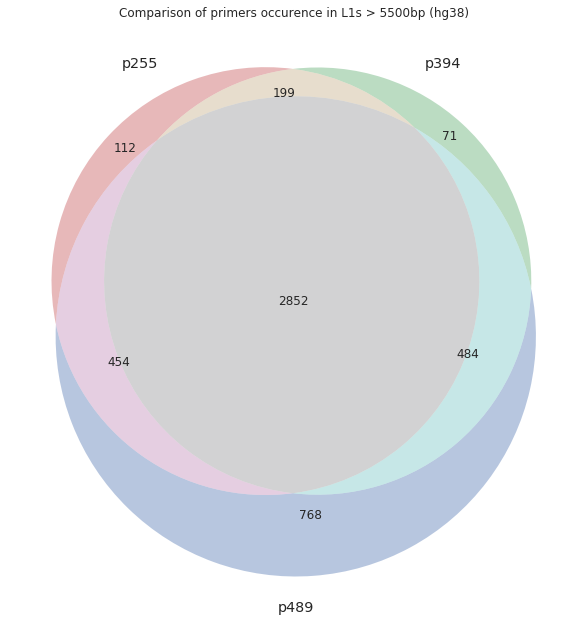

In [326]:
n255 = [rec.id for rec in SeqIO.parse('255.fasta', 'fasta')]
n394 = [rec.id for rec in SeqIO.parse('394.fasta', 'fasta')]
n489 = [rec.id for rec in SeqIO.parse('489.fasta', 'fasta')]
venn3([set(interAB), set(interBC), set(interAC)], 
      set_labels = ('p255', 'p394', 'p489'))
p = plt.title('Comparison of primers occurence in L1s > 5500bp (hg38)')
plt.savefig('Primers_Venn3.png')

### 3b. Comparative stats of paired primers

#### 285 / 394

In [187]:
names = ['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5']
df_285_394 = get_full_stats(reff, names, p255, p394)
df_285_394

idx,name,n,with 255,with 394,with all,only 255,only 394,without
0,L1HS,331,319,318,316,3,2,10
1,L1PA2,1087,1046,1051,1029,17,22,19
2,L1PA3,1567,1232,1429,1186,46,243,92
3,L1PA4,1422,972,636,498,474,138,312
4,L1PA5,1032,48,172,22,26,150,834
5,TOTAL,5439,3617,3606,3051,566,555,1267


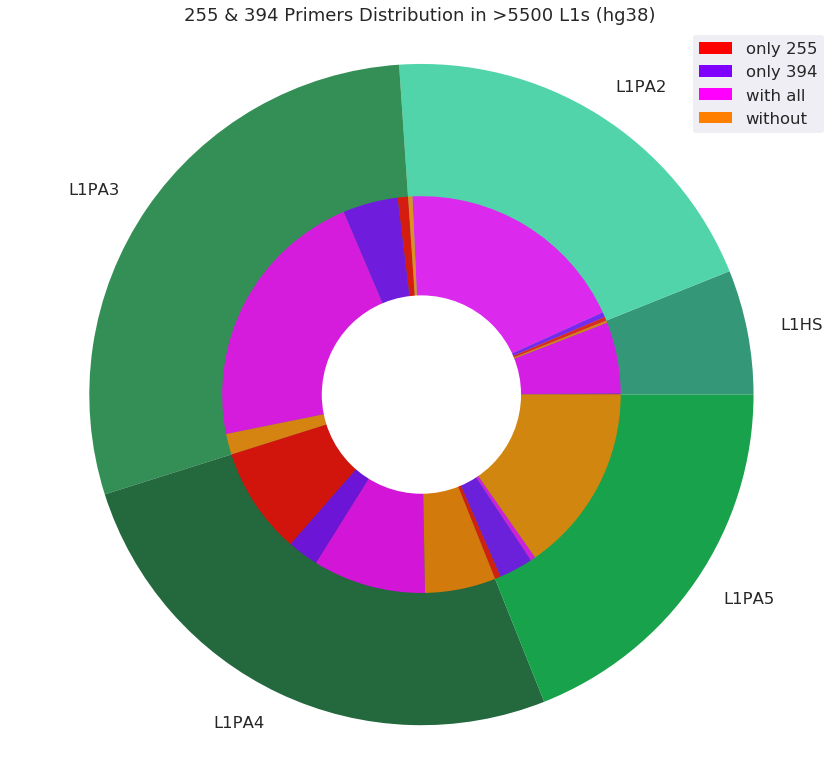

In [224]:
plt = nested_donut(df_285_394)

#### 285 / 489

In [189]:
df_285_489 = get_full_stats(reff, names, p255, p489)
df_285_489

idx,name,n,with 255,with 489,with all,only 255,only 489,without
0,L1HS,331,319,323,315,4,8,4
1,L1PA2,1087,1046,1037,1003,43,34,7
2,L1PA3,1567,1232,1423,1157,75,266,69
3,L1PA4,1422,972,1075,788,184,287,163
4,L1PA5,1032,48,700,43,5,657,327
5,TOTAL,5439,3617,4558,3306,311,1252,570


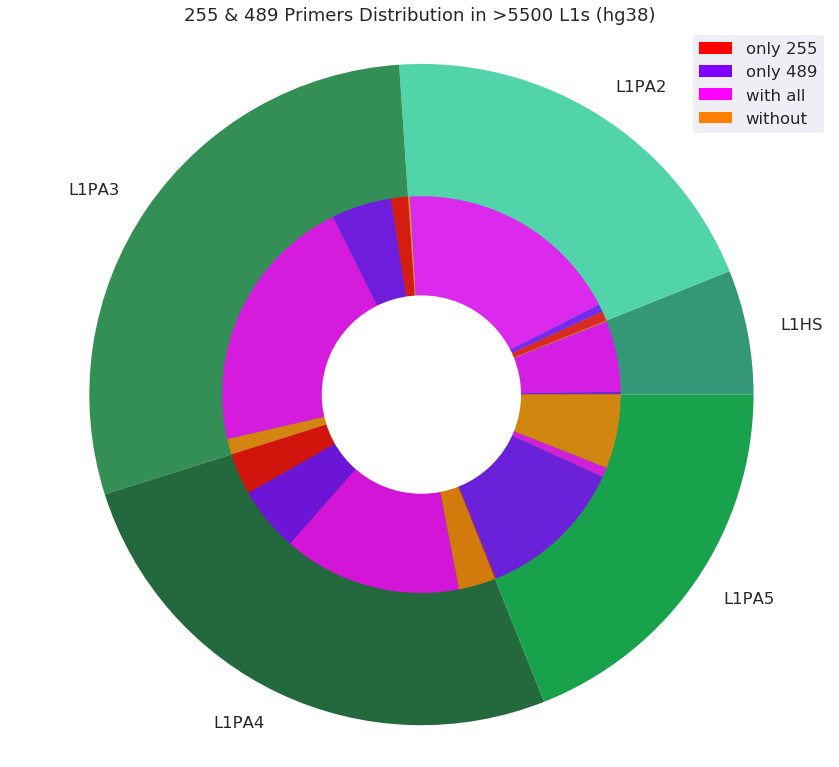

In [225]:
plt = nested_donut(df_285_489)

#### 394 / 489

In [196]:
df_394_489 = get_full_stats(reff, names, p394, p489)
df_394_489

idx,name,n,with 394,with 489,with all,only 394,only 489,without
0,L1HS,331,318,323,314,4,9,4
1,L1PA2,1087,1051,1037,1007,44,30,6
2,L1PA3,1567,1429,1423,1342,87,81,57
3,L1PA4,1422,636,1075,529,107,546,240
4,L1PA5,1032,172,700,144,28,556,304
5,TOTAL,5439,3606,4558,3336,270,1222,611


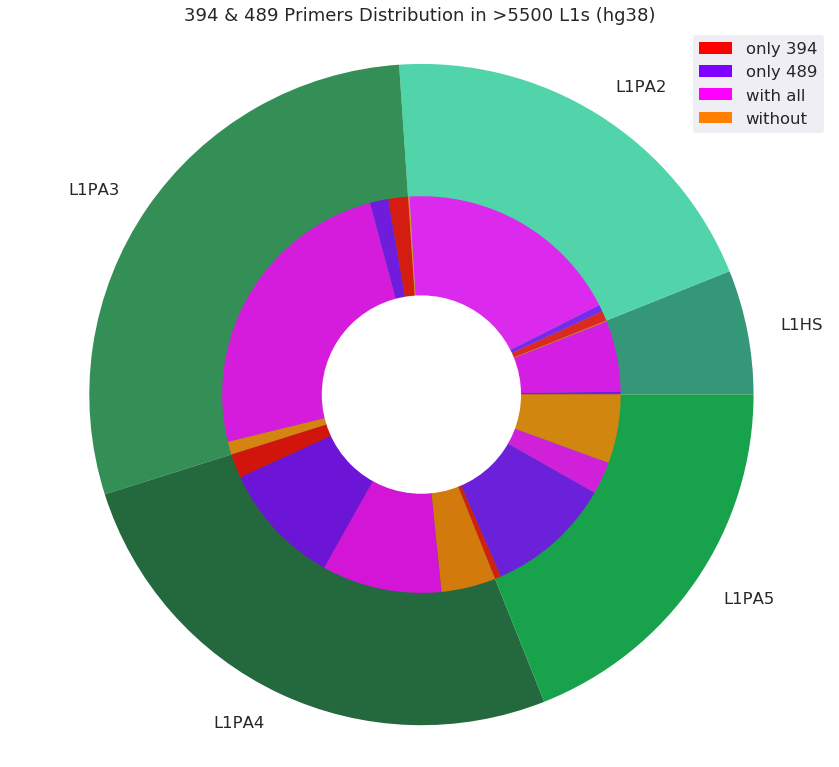

In [226]:
plt = nested_donut(df_394_489)

### 3c. Clustermaps

In [95]:
# generates a pandas dataframe with count of occurences of elements across chromosomes 
def chrom_dist_df(fasta_file):
    chrom_list = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrY', 'chrX']
    l1_list = ['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5']
    chrom_dict = {key: 0 for key in chrom_list}
    t_list = []

    for l1 in l1_list:
        chrom_dict = chrom_dict.fromkeys(chrom_dict, 0)

        for rec in SeqIO.parse(fasta_file, "fasta"):
            if l1 in rec.description:
                for chrom in chrom_list:
                    if len(chrom) == 4:
                        if (rec.id[:4] == chrom) & ('alt' not in rec.id) & ('fix' not in rec.id) & (rec.id[4] == '_'):
                            chrom_dict[chrom] += 1
                    if len(chrom) == 5:
                        if (rec.id[:5] == chrom) & ('alt' not in rec.id) & ('fix' not in rec.id) & (rec.id[5] == '_'):
                            chrom_dict[chrom] += 1

        t_list.append([count for count in chrom_dict.values()])

    total_list = [sum(x) for x in zip(*t_list)]

    df_dict = {'TOTAL': total_list, 'L1HS': t_list[0], 'L1PA2': t_list[1], 
               'L1PA3': t_list[2], 'L1PA4': t_list[3], 'L1PA5': t_list[4]}

    l1_df_chroms = pd.DataFrame(df_dict, index=chrom_list)
    # l1_df_chroms.loc[len(l1_df_chroms)] = l1_df_chroms.iloc[:, 1:].sum().append(pd.Series({'name':'TOTAL'}))
    return l1_df_chroms


In [96]:
def gen_clustermap(df, title, colors, metric):
    sns.set_context("notebook", font_scale=1)
    g = sns.clustermap(df[['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5']], figsize=(20, 15), metric = metric, cmap=colors)
    h = g.ax_heatmap.get_position()
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=11)
    g.ax_heatmap.set_position([h.x0, h.y0, h.width*0.5, h.height])
    col = g.ax_col_dendrogram.get_position()
    g.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.5, col.height*0.5])
    t = g.fig.suptitle(title, y=0.9, x=0.4)
    g.savefig(title)
    return g

In [97]:
metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 
           'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 
           'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 
           'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 
           'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

In [98]:
colors = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 
'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 
'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 
'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 
'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 
'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 
'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 
'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 
'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 
'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 
'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 
'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 
'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 
'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r',
'vlag', 'vlag_r', 'winter', 'winter_r']


#### L1 clustermap

In [99]:
l1_total = 'Flank_L1.fasta'
l1_df = chrom_dist_df(l1_total)
l1_df.to_csv('l1_ditrib_chroms.csv')

In [100]:
# distribution of l1 across chromosomes
l1_df

,TOTAL,L1HS,L1PA2,L1PA3,L1PA4,L1PA5
chr1,340,30,60,101,82,67
chr2,412,24,98,107,102,81
chr3,403,21,85,106,108,83
chr4,442,36,82,125,115,84
chr5,402,24,76,117,108,77
chr6,329,16,65,98,94,56
chr7,261,20,53,68,66,54
chr8,316,13,81,97,68,57
chr9,192,9,40,59,44,40
chr10,213,11,36,61,56,49


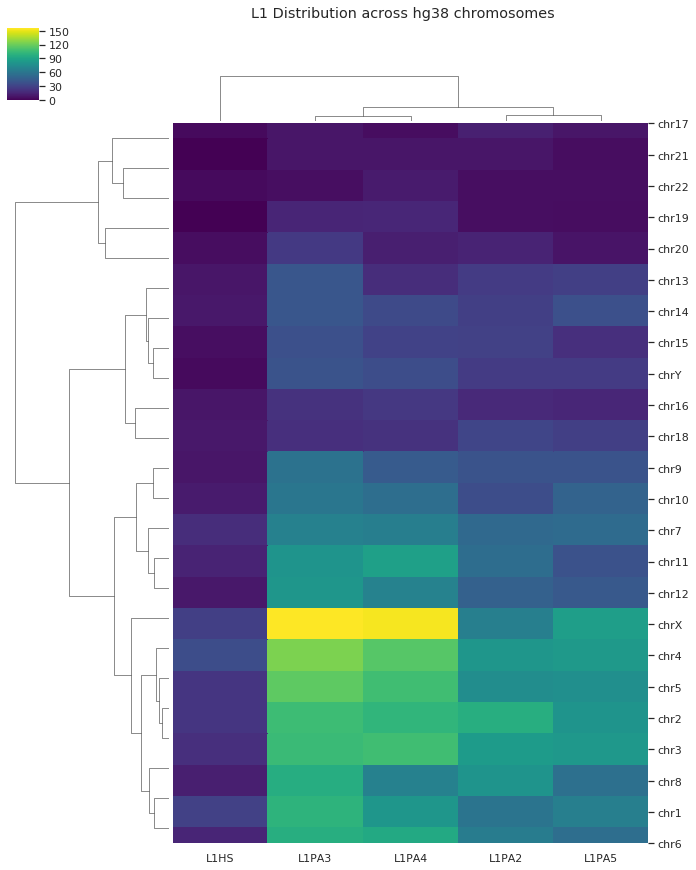

In [101]:
l1_title = 'L1 Distribution across hg38 chromosomes'
l1_colors = 'viridis'
l1_metric = 'braycurtis'

l1_cluster = gen_clustermap(l1_df, l1_title, l1_colors, l1_metric)

In [102]:
fasta_255 = 'c255_flank.fasta'
df_255 = chrom_dist_df(fasta_255)
df_255.to_csv('255_distrib_chroms.csv')

#### 255 clustermap

In [103]:
# distribution of p255 across chromosomes
df_255

,TOTAL,L1HS,L1PA2,L1PA3,L1PA4,L1PA5
chr1,225,29,58,80,52,6
chr2,272,23,94,86,69,0
chr3,265,21,85,82,73,4
chr4,294,34,79,99,81,1
chr5,267,24,75,92,74,2
chr6,220,16,63,79,62,0
chr7,175,20,52,53,47,3
chr8,226,12,78,83,50,3
chr9,126,8,40,48,29,1
chr10,137,11,36,51,38,1


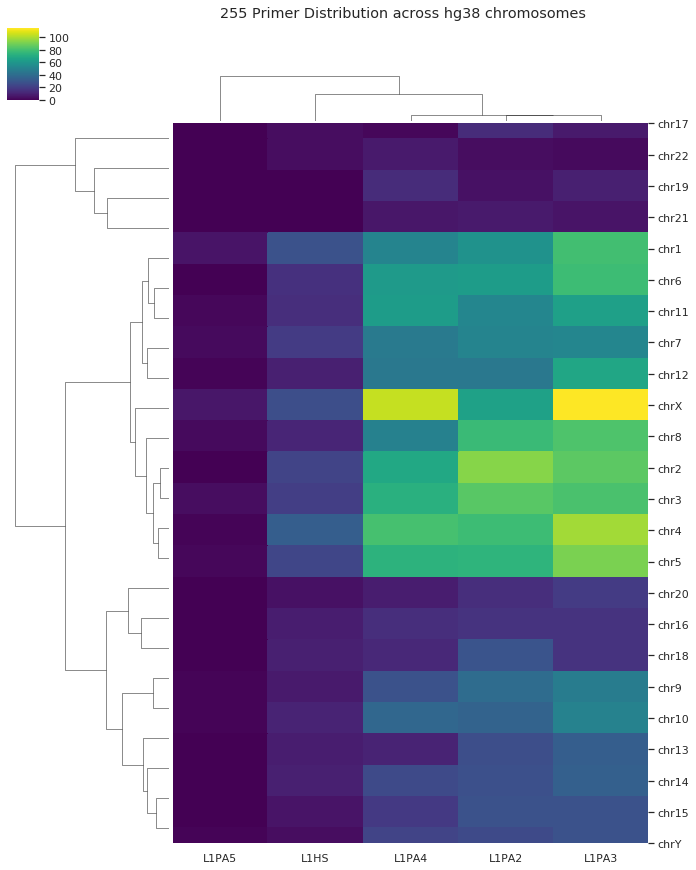

In [104]:
title_255 = '255 Primer Distribution across hg38 chromosomes'
colors_255 = 'viridis'
metric_255 = 'braycurtis'

cluster_255 = gen_clustermap(df_255, title_255, colors_255, metric_255)

#### 394 clustermap

In [105]:
fasta_394 = 'c394_flank.fasta'
df_394 = chrom_dist_df(fasta_394)
df_394.to_csv('394_distrib_chroms.csv')

In [106]:
# distribution of p394 across chromosomes
df_394

,TOTAL,L1HS,L1PA2,L1PA3,L1PA4,L1PA5
chr1,222,29,58,92,36,7
chr2,278,23,97,93,53,12
chr3,257,21,83,93,49,11
chr4,299,34,79,114,56,16
chr5,262,24,76,110,44,8
chr6,222,16,64,92,40,10
chr7,179,19,53,64,31,12
chr8,221,12,78,89,29,13
chr9,129,8,40,55,20,6
chr10,142,11,35,58,27,11


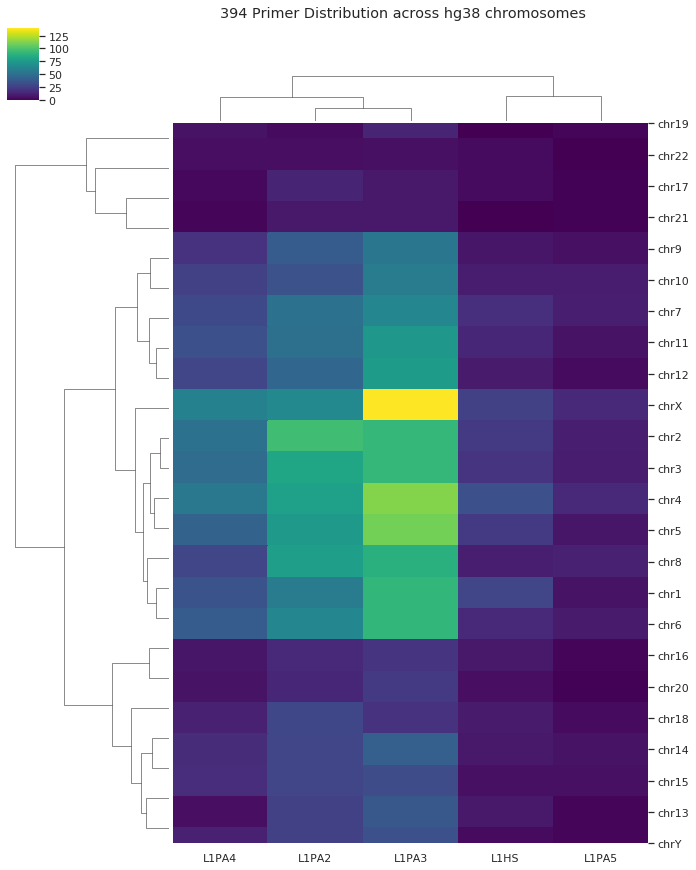

In [107]:
title_394 = '394 Primer Distribution across hg38 chromosomes'
colors_394 = 'viridis'
metric_394 = 'braycurtis'

cluster_394 = gen_clustermap(df_394, title_394, colors_394, metric_394)

#### 489 clustermap

In [108]:
fasta_489 = 'c489_flank.fasta'
df_489 = chrom_dist_df(fasta_489)
df_489.to_csv('c489_distrib_chroms.csv')

In [109]:
# distribution of p489 across chromosomes
df_489

,TOTAL,L1HS,L1PA2,L1PA3,L1PA4,L1PA5
chr1,290,30,59,94,60,47
chr2,344,24,96,97,75,52
chr3,330,20,83,98,78,51
chr4,377,34,78,112,91,62
chr5,332,24,71,110,76,51
chr6,280,16,60,91,72,41
chr7,224,20,53,64,50,37
chr8,266,13,77,85,48,43
chr9,157,8,40,53,29,27
chr10,184,11,35,56,50,32


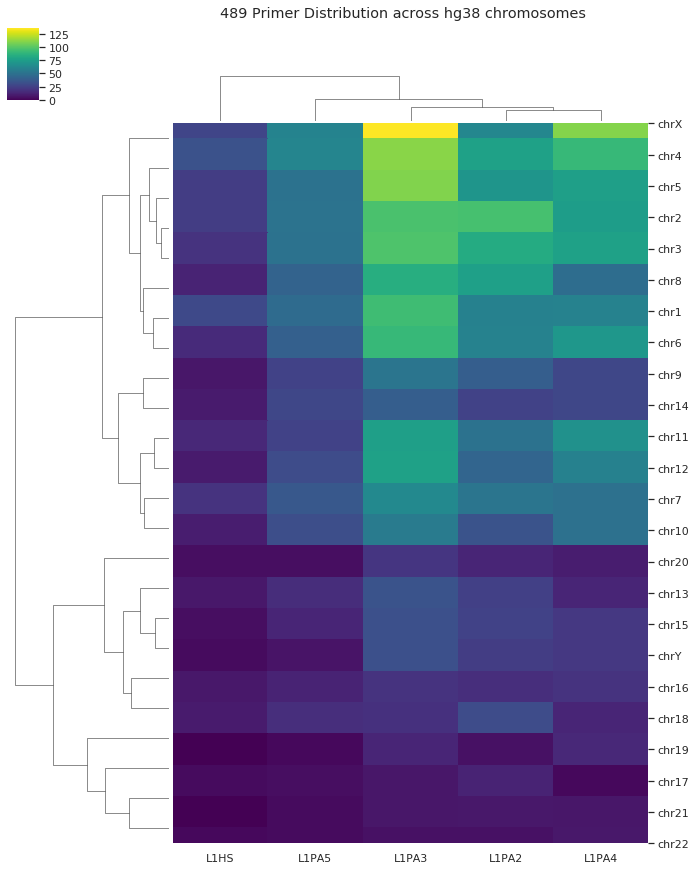

In [110]:
title_489 = '489 Primer Distribution across hg38 chromosomes'
colors_489 = 'viridis'
metric_489 = 'braycurtis'

g = gen_clustermap(df_489, title_489, colors_489, metric_489)

## 4. Duplicates concatenation in primers flank sequences

### 4a. Generate new fasta files with only 300bp flank

In [331]:
# strips a list of fasta files' records
# write new fasta with input filename + _flank
def strip_flank_to_fasta(*fasta):
    for fasta_file in fasta:
        new_recs = []
        for record in SeqIO.parse(fasta_file, "fasta"):
            new_rec = record
            new_rec.seq = record.seq[0:300]
            new_recs.append(new_rec)
        recs_gen = (rec for rec in new_recs)
        out_fasta = f'{fasta_file[:-6]}_flank.fasta'
        count = SeqIO.write(recs_gen, out_fasta, 'fasta')
        print(f'{count} records reduced to 300bp flank in "{out_fasta}"')

In [332]:
p255 = 'c255.fasta'
p394 = 'c394.fasta'
p489 = 'c489.fasta'
strip_flank_to_fasta(p255, p394, p489)

3617 records reduced to 300bp flank in "255_flank.fasta"
3606 records reduced to 300bp flank in "394_flank.fasta"
4558 records reduced to 300bp flank in "489_flank.fasta"


### 4b. Concatenate duplicates for each primer flank sequence series

In [111]:
# concatenate multiple duplicates (X=A / B=X / B=C ==> X|A|B|C...)
# sequences comparison based on strict string equality
# takes an input fasta file, writes a new fasta with filename + _dup
# returns a pandas dataframe of dup stats
def dup_concat(in_fasta):
    # collect records in list and count
    dup_recs = []
    init_count = 0
    hs_count = 0
    pa2_count = 0
    pa3_count = 0
    pa4_count = 0
    pa5_count = 0
    for rec in SeqIO.parse(in_fasta, "fasta"):
        init_count += 1
        dup_recs.append(rec)
        if 'L1HS' in rec.id:
            hs_count += 1
        if 'L1PA2' in rec.id:
            pa2_count += 1
        if 'L1PA3' in rec.id:
            pa3_count += 1
        if 'L1PA4' in rec.id:
            pa4_count += 1
        if 'L1PA5' in rec.id:
            pa5_count += 1
        
    # create duplicates indexes list to remove
    # dictionary where shared sequence is key, list of IDs that share this sequence as value
    dic_list = []
    remove_list = []
    dup_idx = 0
    for dup in dup_recs:
        d_idx = 0
        for d in dup_recs:
            if (dup.seq._data == d.seq._data) and (dup.id != d.id):
                if not any(dup.seq._data in d for d in dic_list):
                    seqdic = {dup.seq._data:[dup.id, d.id]}
                    dic_list.append(seqdic)
                    remove_list.append(dup_idx)
                    remove_list.append(d_idx)
                else:
                    for dic in dic_list:
                        for k, v in dic.items():
                            if k == dup.seq._data:
                                if d.id not in v:
                                    v.append(d.id)
                                    remove_list.append(d_idx)     
            d_idx += 1
        dup_idx += 1
    
    dupN = len(remove_list)
    concatN = len(dic_list)
    
    # remove duplicates from list
    for idx in reversed(sorted(remove_list)):
        del dup_recs[idx]
    
    # create new list of duplicate records
    multi_dups = []
    for dic in dic_list:
        same_recs = []
        for k, v in dic.items():
            for x in v:
                new_rec = SeqRecord(Seq(k, generic_dna), name="", description="")
                new_rec.id = x
                same_recs.append(new_rec)
        multi_dups.append(same_recs)
    
    # count duplicates per type for stats
    dup_count = 0
    hs_dup_count = 0
    pa2_dup_count = 0
    pa3_dup_count = 0
    pa4_dup_count = 0
    pa5_dup_count = 0
    for multi in multi_dups:
        for x in multi:
            dup_count += 1
            if 'L1HS' in x.id:
                hs_dup_count += 1
            if 'L1PA2' in x.id:
                pa2_dup_count += 1
            if 'L1PA3' in x.id:
                pa3_dup_count += 1
            if 'L1PA4' in x.id:
                pa4_dup_count += 1
            if 'L1PA5' in x.id:
                pa5_dup_count += 1
                
    # concatenate duplicate records with different IDs
    concat_recs = []
    for dic in dic_list:
        ids_list = []
        for dna_seq, id_list in dic.items():
            for _id in id_list:
                ids_list.append(_id)
            seq = Seq(dna_seq, generic_dna)
            new_id = '|'.join(ids_list)
            new_rec = SeqRecord(seq, name="", description="")
            new_rec.id = new_id
            concat_recs.append(new_rec)
            
    # add concat records back to list       
    for dup in concat_recs:
        dup_recs.append(dup)
    
    # write new fasta with new list
    recs_gen = (rec for rec in dup_recs)
    out_fasta = f'{in_fasta[:-6]}_dup.fasta'
    count = SeqIO.write(recs_gen, out_fasta, 'fasta')
    
    print(f'{dupN} duplicates concatenated in {concatN} records out of {init_count} initial\n{count} records dumped in new fasta file "{out_fasta}"')
    
    idx_list = ['L1HS', 'L1PA2', 'L1PA3', 'L1PA4', 'L1PA5', 'TOTAL']
    n_list = [hs_count, pa2_count, pa3_count, pa4_count, pa5_count, init_count]
    dup_list = [hs_dup_count, pa2_dup_count, pa3_dup_count, pa4_dup_count, pa5_dup_count, dup_count]

    stat_dic = {'n': n_list, 'dup': dup_list}

    df = pd.DataFrame(stat_dic, index = idx_list)
    pd.options.display.float_format = '{:.2f}'.format
    df['%'] = round(df.dup * 100 / df.n, 2)
    stat_df = df.rename_axis(columns=f'{in_fasta[:4]}')
    
    return stat_df

#### 255 dups

In [112]:
f255 = '255_flank.fasta'
dup_stat_255_df = dup_concat(f255)
dup_stat_255_df.to_csv('255_dup_stat.csv')

124 duplicates concatenated in 56 records out of 3617 initial
3549 records dumped in new fasta file "255_flank_dup.fasta"


In [113]:
dup_stat_255_df

255,n,dup,%
L1HS,319,8,2.51
L1PA2,1046,30,2.87
L1PA3,1232,25,2.03
L1PA4,972,48,4.94
L1PA5,48,13,27.08
TOTAL,3617,124,3.43


#### 394 dups

In [114]:
f394 = '394_flank.fasta'
dup_stat_394_df = dup_concat(f394)
dup_stat_394_df.to_csv('255_dup_stat.csv')

116 duplicates concatenated in 55 records out of 3606 initial
3545 records dumped in new fasta file "394_flank_dup.fasta"


In [115]:
dup_stat_394_df

394,n,dup,%
L1HS,318,10,3.14
L1PA2,1051,30,2.85
L1PA3,1429,28,1.96
L1PA4,636,38,5.97
L1PA5,172,10,5.81
TOTAL,3606,116,3.22


#### 489 dups

In [116]:
f489 = '489_flank.fasta'
dup_stat_489_df = dup_concat(f489)
dup_stat_489_df.to_csv('255_dup_stat.csv')

162 duplicates concatenated in 75 records out of 4558 initial
4471 records dumped in new fasta file "489_flank_dup.fasta"


In [117]:
dup_stat_489_df

489,n,dup,%
L1HS,323,12,3.72
L1PA2,1037,37,3.57
L1PA3,1423,33,2.32
L1PA4,1075,48,4.47
L1PA5,700,32,4.57
TOTAL,4558,162,3.55


## 5. C-T conversion

In [120]:
# Convert C by T except in CpGs
# takes a variables number of fasta files
# writes new converted fasta with filenames + CT
def convert_ct_to_fasta(*fasta):
    for fasta_file in fasta:
        new_recs_list = []
        for rec in SeqIO.parse(fasta_file, "fasta"):
            new_rec = rec
            new_seq_list = list(new_rec.seq)
            if new_seq_list[-1] ==  'C':
                new_seq_list[-1:] = 'T'
            for i in range(len(new_seq_list) - 1):
                if (new_seq_list[i] == 'C') & (new_seq_list[i+1] != 'G'):
                    new_seq_list[i] = 'T'               
            new_rec.seq = Seq(''.join(new_seq_list), generic_dna)
            new_recs_list.append(new_rec)
        rec_gen = (rec for rec in new_recs_list)
        out_fasta = f'{fasta_file[:-6]}_T.fasta'
        count = SeqIO.write(rec_gen, out_fasta, 'fasta')
        print(f'converted {count} records with C->T in {out_fasta}')

In [121]:
d255 = '255_flank_dup.fasta'
d394 = '394_flank_dup.fasta'
d489 = '489_flank_dup.fasta'
convert_ct_to_fasta(d255, d394, d489)

converted 3549 records with C->T in 255_flank_dup_T.fasta
converted 3545 records with C->T in 394_flank_dup_T.fasta
converted 4471 records with C->T in 489_flank_dup_T.fasta


## 6. Minimal flank distance analysis

In [2]:
%cd work

/mnt/nfs/home/244205/000000-My_Documents/VM-home/l1_parse/work


In [3]:
# calculates minimal distance of a series of fastas
# returns a pandas dataframe
def get_min_dist(length, *fasta):
    count_dic = {} 
    for f in fasta:
        count_list = []
        for i in range(length):
            temp_list = []
            for rec in SeqIO.parse(f, 'fasta'):
                temp_list.append(rec.seq._data[:i+1])
            count_list.append(len(temp_list) - len(set(temp_list)))
        count_dic[f'{f[:4]}'] = count_list
    
    idx = [i for i in range(1,length+1)]
    rdf = pd.DataFrame(count_dic,index=idx)
    rdf.columns.name='nt'
    
    return rdf

In [4]:
with open('../files/plotly_colors.csv', 'rt') as f:
    reader = csv.reader(f)
    plotly_colors = list(reader)
print(plotly_colors[0])

['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'gold', 'goldenrod', 'gray', 'grey', 'green', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory', 'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgrey', 'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen', 

In [5]:
# takes a dataframe of any number of columns, returns a fig and exports image
def plot_min_dist(rdf):
    fig = go.Figure()
    sub_colors = ['lightcyan', 'hotpink', 'goldenrod', 'orange', 'peachpuff', 'lightseagreen', 'yellow', 'powderblue', 'slategray', 'rosybrown']
    while True:
        color_choice = []
        for i in range(len(rdf.columns)):
            color_choice.append(random.choice(sub_colors))
        if len(set(color_choice)) == len(rdf.columns):
            break
            
    idx = 0
    for col in rdf.columns:
        fig.add_trace(go.Scatter(x=rdf.index, y=rdf[col],
                            mode='lines+markers',
                            name=col,
                            line={'color': color_choice[idx]}))
        idx += 1
    
    fig.update_layout(
        title = 'Minimal distance of primers flank sequences',
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 200,
            showgrid=True,
            gridcolor="rgb(250, 250, 250)",
            title='number of matches'
        ),
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 1,
            showgrid=True,
            gridcolor="rgb(250, 250, 250)",
            title="nt position from 5' end"
        ),
        plot_bgcolor = "rgb(221, 231, 237)",
        width=680, height=920)
    
    return fig

In [6]:
d255 = 'c255_flank_dup.fasta'
d394 = 'c394_flank_dup.fasta'
d489 = 'c489_flank_dup.fasta'
t255 = 't255_flank_dup.fasta'
t394 = 't394_flank_dup.fasta'
t489 = 't489_flank_dup.fasta'

In [8]:
# minimal flank distance dataframe
rdf = get_min_dist(23, d255, d394, d489, t255, t394, t489)
rdf.to_csv('../result/23nt_min_dist_flank.csv')
rdf

nt,c255,c394,c489,t255,t394,t489
1,3544,3540,4466,3544,3540,4466
2,3532,3528,4454,3535,3531,4457
3,3484,3480,4406,3506,3502,4429
4,3308,3304,4226,3429,3425,4349
5,2716,2724,3615,3227,3230,4145
6,1598,1614,2301,2799,2801,3678
7,712,706,1073,2112,2082,2842
8,279,273,442,1400,1382,1974
9,120,121,208,822,808,1196
10,76,76,130,450,437,692


In [9]:
plotly.offline.init_notebook_mode(connected=True)

In [10]:
fig= plot_min_dist(rdf)
filename = '23nt_min_dist_flank.png'
plotly.offline.iplot(fig)

In [11]:
pio.write_image(fig, '../result/23nt_min_dist_flank.svg')